## Authenticate to Colab, Cloud and GEE

In [ ]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/Classification/USA/Yolo_2/'
model_dir = base_dir + 'models/'
IMAGES_PATH = base_dir + '/' + 'Yolo_2016_16c/'

sys.path.append(base_dir) 

Mounted at /content/gdrive/


## Import Libraries

In [ ]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
print(tf.__version__)
import folium
print(folium.__version__)

2.4.0
0.8.3


# Initialize global variables and functions

In [ ]:
LABEL = 'landcover'


# landcovers = ['Rice', 'Alfalfa', 'Wheat', 'Sunflower', 'Safflower', 'Corn', 'YP', 'Tomatoes', 
#               'Grain and Hay', 'Grapes', 'Deciduous','Subtropical', 'Other Grass', 'Other Crops',
#               'Wetland', 'Fallowland', 'Buildup']
landcovers = ["Rice", "Safflower", "Corn", "Other Field crops", "Alfalfa", "Other Pasture", "Cucurbits", "Tomatoes", 
             "Other Truck Crops", "Almonds and pistachios", "Other Deciduous", "Subtropical", "Vineyards", "Other"]
nClasses = 16
r = 7

In [ ]:
# new_labels = tf.constant([0,1,2,3,4,5,6,13,7,13,13,13,13,13,10,13,13,13,13,8,13,13,11,10,10,10,10,9,10,10,11,11,10,10,11,13,12,10,12,13,14,15,16], dtype = tf.int32,)
new_labels = tf.constant([0,4,13,3,1,2,13,6,7,8,8,8,8,8,10,3,8,8,8,13,3,8,11,10,9,9,10,12,10,10,11,11,10,10,11,8,5,10,5,8,13,13,13], dtype = tf.int32,)

new_labels

<tf.Tensor: shape=(43,), dtype=int32, numpy=
array([ 0,  4, 13,  3,  1,  2, 13,  6,  7,  8,  8,  8,  8,  8, 10,  3,  8,
        8,  8, 13,  3,  8, 11, 10,  9,  9, 10, 12, 10, 10, 11, 11, 10, 10,
       11,  8,  5, 10,  5,  8, 13, 13, 13], dtype=int32)>

In [ ]:
train_path = IMAGES_PATH + 'training_yolo_2016_16c'
validation_path = IMAGES_PATH + 'validation_yolo_2016_16c'
test_path = IMAGES_PATH + 'testing_yolo_2016_16c'

train_file_prefix = 'training_yolo_2016'
validation_file_prefix = 'validation_yolo_2016'
test_file_prefix = 'testing_yolo_2016'

def getDatasetPaths(path, image_file_prefix):
  filesList = listdir(path = path)
  exportFilesList = [s for s in filesList if image_file_prefix in s]
  imageFilesList = []

  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  datasetPaths = [path + '/' + f for f in imageFilesList] 
  return datasetPaths

train_dataset_paths = getDatasetPaths(train_path, train_file_prefix)
validation_dataset_paths = getDatasetPaths(validation_path, validation_file_prefix)
test_dataset_paths = getDatasetPaths(test_path, test_file_prefix)


In [ ]:
# validation_dataset_paths

In [ ]:
FEATURE_NAMES = []
bands =  ['B2', 'B3', 'B4', 'B5', 'B6','B7', 'NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI']

time_stamps = 9
n_features = len(bands)
for i in range(time_stamps):
  if i > 0:
    s = [b + '_' + str(i) for b in bands]
  else:
    s = bands
  FEATURE_NAMES.extend(s)
FEATURE_NAMES.append(LABEL)
# for b in bands:
#   for i in range(time_stamps):
#     if i > 0:
#       s = b + '_' + str(i)
#     else:
#       s = b
#     FEATURE_NAMES.append(s)  
  
# FEATURE_NAMES.append(LABEL)
# FEATURE_NAMES

# Data preparation and pre-processing

In [ ]:
# List of fixed-length features, all of which are float32.
from pprint import pprint
import numpy as np
# z = np.zeros(91,).tolist()

columns = [
  tf.io.FixedLenSequenceFeature(shape=[r,r], dtype=tf.float32, allow_missing = True) for k in FEATURE_NAMES
]
# Dictionary with names as keys, features as values.
from collections import OrderedDict 

# featuresDict = dict(zip(FEATURE_NAMES, columns))
featuresDict = OrderedDict(zip(FEATURE_NAMES, columns))

# pprint(featuresDict)

In [ ]:
# Create a dataset from the TFRecord file in Cloud Storage.

depth = len(FEATURE_NAMES)-1
def toTuple(data, label):
  spectral = []
  for i in range(0, depth, n_features):
    band_values = []
    for f in FEATURE_NAMES[i:i+n_features]:
      if f.startswith('B'):
        band_values.append(tf.reshape(data[f],(r,r))/10000)
      else:   
        band_values.append(tf.reshape(data[f],(r,r)))
    spectral.append(band_values)
  
  spectral = tf.transpose(spectral, [2,3,0,1])
  label = tf.gather(new_labels, label)

  return spectral, label

def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(LABEL)
  labels = tf.cast(labels, tf.int32)
  label = tf.math.argmax(tf.math.bincount(labels))
  return parsed_features, label

def getDataset(datasetPaths):
  dataset = tf.data.TFRecordDataset(datasetPaths, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(toTuple)
  return inputDataset

trainDataset = getDataset(train_dataset_paths)
validationDataset = getDataset(validation_dataset_paths)
testDataset = getDataset(test_dataset_paths)
alltestDataset = validationDataset.concatenate(testDataset)

In [ ]:
for data, target in testDataset.take(5):
  print(data.shape)
  print(data[0][0])
  print(target)

(7, 7, 9, 13)
tf.Tensor(
[[ 8.41400027e-01  7.97699988e-01  6.84800029e-01  1.79310000e+00
   8.94400001e-01  6.79899991e-01  4.47273910e-01  3.84205639e-01
  -6.78274155e+00 -1.14228860e-01 -2.50444973e-05 -3.84205639e-01
  -3.34399998e-01]
 [ 8.41400027e-01  7.97699988e-01  6.84800029e-01  1.79310000e+00
   8.94400001e-01  6.79899991e-01  4.47273910e-01  3.84205639e-01
  -6.78274155e+00 -1.14228860e-01 -2.50444973e-05 -3.84205639e-01
  -3.34399998e-01]
 [ 1.12664998e+00  1.15139997e+00  1.28729999e+00  1.64279997e+00
   1.93414998e+00  1.62995005e+00  1.21328264e-01  1.75858691e-01
   9.76435304e-01  8.35785419e-02  7.54379198e-06 -1.75858691e-01
   8.14057291e-02]
 [ 8.99699986e-01  8.19800019e-01  7.61900008e-01  8.70599985e-01
   6.59099996e-01  6.04300022e-01  6.65849894e-02  3.00520584e-02
  -2.08133876e-01 -5.49075380e-02 -1.09453831e-05 -3.00520584e-02
  -1.38262406e-01]
 [ 8.95500004e-01  8.19999993e-01  6.97300017e-01  1.36230004e+00
   9.26100016e-01  7.07499981e-01  3.2287

# Models

##  Our 3DCNN

In [ ]:
pad = 'same'
l2 = 0
l1 = 0
f = [64, 128]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = ( r, r, time_stamps,n_features),),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(filters = f[0], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.Conv3D(filters = f[0], kernel_size = (3, 3, 3), padding = 'same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)),

    tf.keras.layers.Conv3D(filters = f[1], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.Conv3D(filters = f[1], kernel_size = (3, 3, 3), padding = 'same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = 'relu',  kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
    tf.keras.layers.Dense(14, activation = 'softmax')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_36 (Batc (None, 7, 7, 9, 13)       52        
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 7, 7, 9, 64)       22528     
_________________________________________________________________
batch_normalization_37 (Batc (None, 7, 7, 9, 64)       256       
_________________________________________________________________
re_lu_26 (ReLU)              (None, 7, 7, 9, 64)       0         
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 3, 3, 9, 64)       0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 3, 3, 9, 128)      221312    
_________________________________________________________________
batch_normalization_38 (Batc (None, 3, 3, 9, 128)    

## Paper 3D CNN

In [ ]:
pad = 'same'
l2 = 0
l1 = 0
f = [32, 64]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = ( r, r, time_stamps,n_features),),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(filters = f[0], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.AveragePooling3D(pool_size=(2, 2, 1)),

    tf.keras.layers.Conv3D(filters = f[1], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.AveragePooling3D(pool_size=(2, 2, 1)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(f[1], activation = 'relu',  kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
    tf.keras.layers.Dense(14, activation = 'softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 7, 7, 9, 13)       52        
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 7, 7, 9, 32)       11264     
_________________________________________________________________
re_lu_9 (ReLU)               (None, 7, 7, 9, 32)       0         
_________________________________________________________________
average_pooling3d_6 (Average (None, 3, 3, 9, 32)       0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 3, 3, 9, 64)       55360     
_________________________________________________________________
re_lu_10 (ReLU)              (None, 3, 3, 9, 64)       0         
_________________________________________________________________
average_pooling3d_7 (Average (None, 1, 1, 9, 64)      

## Ensemble

In [ ]:
def unit(f = [32, 64]):
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = ( r, r, time_stamps,n_features),),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(filters = f[0], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)),

    tf.keras.layers.Conv3D(filters = f[1], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)),

  ])
  return model



def model():
  input = tf.keras.layers.Input(shape = ( r, r, time_stamps, n_features))
  x = tf.keras.layers.BatchNormalization()(input)
  unit1 = unit([32, 64])(x)
  unit2 = unit([48, 96])(x)
  unit3 = unit([64, 128])(x)
  unit1 = tf.squeeze(tf.squeeze(unit1, axis = 1), axis = 1)
  unit2 = tf.squeeze(tf.squeeze(unit2, axis = 1), axis = 1)
  unit3 = tf.squeeze(tf.squeeze(unit3, axis = 1), axis = 1)
  x = tf.keras.layers.Concatenate()([unit1, unit2, unit3])
  x = tf.keras.layers.Conv1D(128, 3, padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool1D()(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation = 'relu')(x)
  x = tf.keras.layers.Dense(14, activation = 'softmax')(x)
  model = tf.keras.Model(input, x)
  return model

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 7, 7, 9, 13) 0                                            
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 7, 7, 9, 13)  52          input_5[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1, 1, 9, 64)  67060       batch_normalization_11[0][0]     
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1, 1, 9, 96)  142036      batch_normalization_11[0][0]     
______________________________________________________________________________________________

# Conv3D w/ LSTM

In [ ]:
input = tf.keras.layers.Input((r,r,time_stamps,n_features))
x = tf.keras.layers.BatchNormalization()(input)

x = tf.keras.layers.Conv3D(filters = 64, kernel_size = (3, 3, 3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPool3D((2,2,1))(x)

x = tf.keras.layers.Conv3D(filters = 128, kernel_size = (3, 3, 3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPool3D((2,2,1))(x)
x = tf.squeeze(tf.squeeze(x, axis = 1), axis = 1)
# x = tf.keras.layers.LSTM(units = 128, return_sequences = False, recurrent_dropout = 0.2)(x)


x = tf.keras.layers.Conv1D(128, kernel_size = 3, padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPooling1D()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(14, activation = 'softmax')(x)
model = tf.keras.Model(input, x)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 7, 7, 9, 13)]     0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 7, 7, 9, 13)       52        
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 7, 7, 9, 64)       22528     
_________________________________________________________________
batch_normalization_45 (Batc (None, 7, 7, 9, 64)       256       
_________________________________________________________________
re_lu_36 (ReLU)              (None, 7, 7, 9, 64)       0         
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 3, 3, 9, 64)       0         
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 3, 3, 9, 128)      2213

# Training

In [ ]:
batch_size = 128
num_epochs = 60

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=3, min_lr=1e-10, min_delta=0.003, verbose = 1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    model_dir + '/model2_3d1d_conv3d_2016_7x7x9x13_13c', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

history = model.fit(trainDataset.batch(batch_size), 
                    batch_size=batch_size, 
                    epochs=num_epochs, verbose=1,
                    validation_data = alltestDataset.batch(batch_size),
                    callbacks = [reduce_lr, 
                                 model_checkpoint_callback
                                 ]
)

In [ ]:
model.summary()

In [ ]:
# model = tf.keras.models.load_model(model_dir + '/model3_conv3d_2016_7x7x9x13')
# model = tf.keras.models.load_model(model_dir + '/model4_conv3d_2016_7x7x9x6')
# model = tf.keras.models.load_model(model_dir + '/model5_conv3d_2016_7x7x9x6_43c')
# model = tf.keras.models.load_model(model_dir + '/model6_conv3d_2016_7x7x9x6_13c')
# model = tf.keras.models.load_model(model_dir + '/model7_conv3d_2016_7x7x9x13_13c')
#------------------------------------------------------------------------------------#
# model = tf.keras.models.load_model(model_dir + '/model8_conv3d_2016_7x7x9x13_13c') #89.27%
# model = tf.keras.models.load_model(model_dir + '/model_paper_conv3d_2016_7x7x9x13_13c') #87.59
# model = tf.keras.models.load_model(model_dir + '/model2_paper_conv3d_2016_7x7x9x13_13c') #88.01

# model = tf.keras.models.load_model(model_dir + '/model9_conv3d_2016_7x7x9x13_13c') #ensemble #89.78%
# model = tf.keras.models.load_model(model_dir + '/model10_conv3d_2016_7x7x9x13_13c') # 89.70%
# model = tf.keras.models.load_model(model_dir + '/model11_conv3d_2016_7x7x9x13_13c') #89.53
# model = tf.keras.models.load_model(model_dir + '/model_ensemble_conv3d_2016_7x7x9x13_13c') #
# model = tf.keras.models.load_model(model_dir + '/model_convlstm_conv3d_2016_7x7x9x13_13c') #90.23
# model = tf.keras.models.load_model(model_dir + '/model_3d1d_conv3d_2016_7x7x9x13_13c') #90.22
# model = tf.keras.models.load_model(model_dir + '/model2_3d1d_conv3d_2016_7x7x9x13_13c') #89.86%


In [ ]:
 model.evaluate(alltestDataset.batch(1000))

128/128 [==============================] - 49s 379ms/step - loss: 0.8642 - accuracy: 0.9022


[0.8642063736915588, 0.902229368686676]

# Analysis

In [ ]:
y_pred = np.argmax(model.predict(alltestDataset.batch(10000)),axis = 1)
y_true = tf.concat([y for x, y in alltestDataset], axis=0)
# f1_score(y_true.numpy(), y_pred, average = 'weighted')
cf = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

print(cf)
s = np.sum(cf, axis = 1)

# cf1 = pd.DataFrame(cf/(s.reshape(nClasses-1, 1)), columns=landcovers[:-1], index = landcovers[:-1])
cf1 = pd.DataFrame(cf/(s.reshape(14, 1))*100, columns=landcovers, index = landcovers)



[[13713     8    27     6     6     6    20   150     1    26    28     1
      6   383]
 [    1  2984    22    20    74     2    10    32     2     7     0     0
      7   168]
 [    9    32  1634   428    39    18   177   119     4     0     1     0
      3   177]
 [   55   266    72  6147    20     3    92   464    84    15     8     0
     10   388]
 [    3    76    65    22  9359   102     3    18    20     7    19     0
     26   302]
 [   10     0    76     6   241  3898     0     1    27    16     9     2
      1   486]
 [    3     6    37    48    17     0  1602   152    59     0     7     0
      3   144]
 [   11    13    92   124    19     0   142  9318    24    17     5     0
      5   236]
 [   14    12    67    55    24     4   206   237   784    27    20     2
      7   423]
 [   26     9     3     3    28     2     5    10    14  8882   133    11
    123  1305]
 [   20    12     2     5    41    20     3    16    21    97  5476     7
     70   302]
 [   15     0     0  

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true.numpy(), y_pred, average = 'weighted')


0.9003506453666142

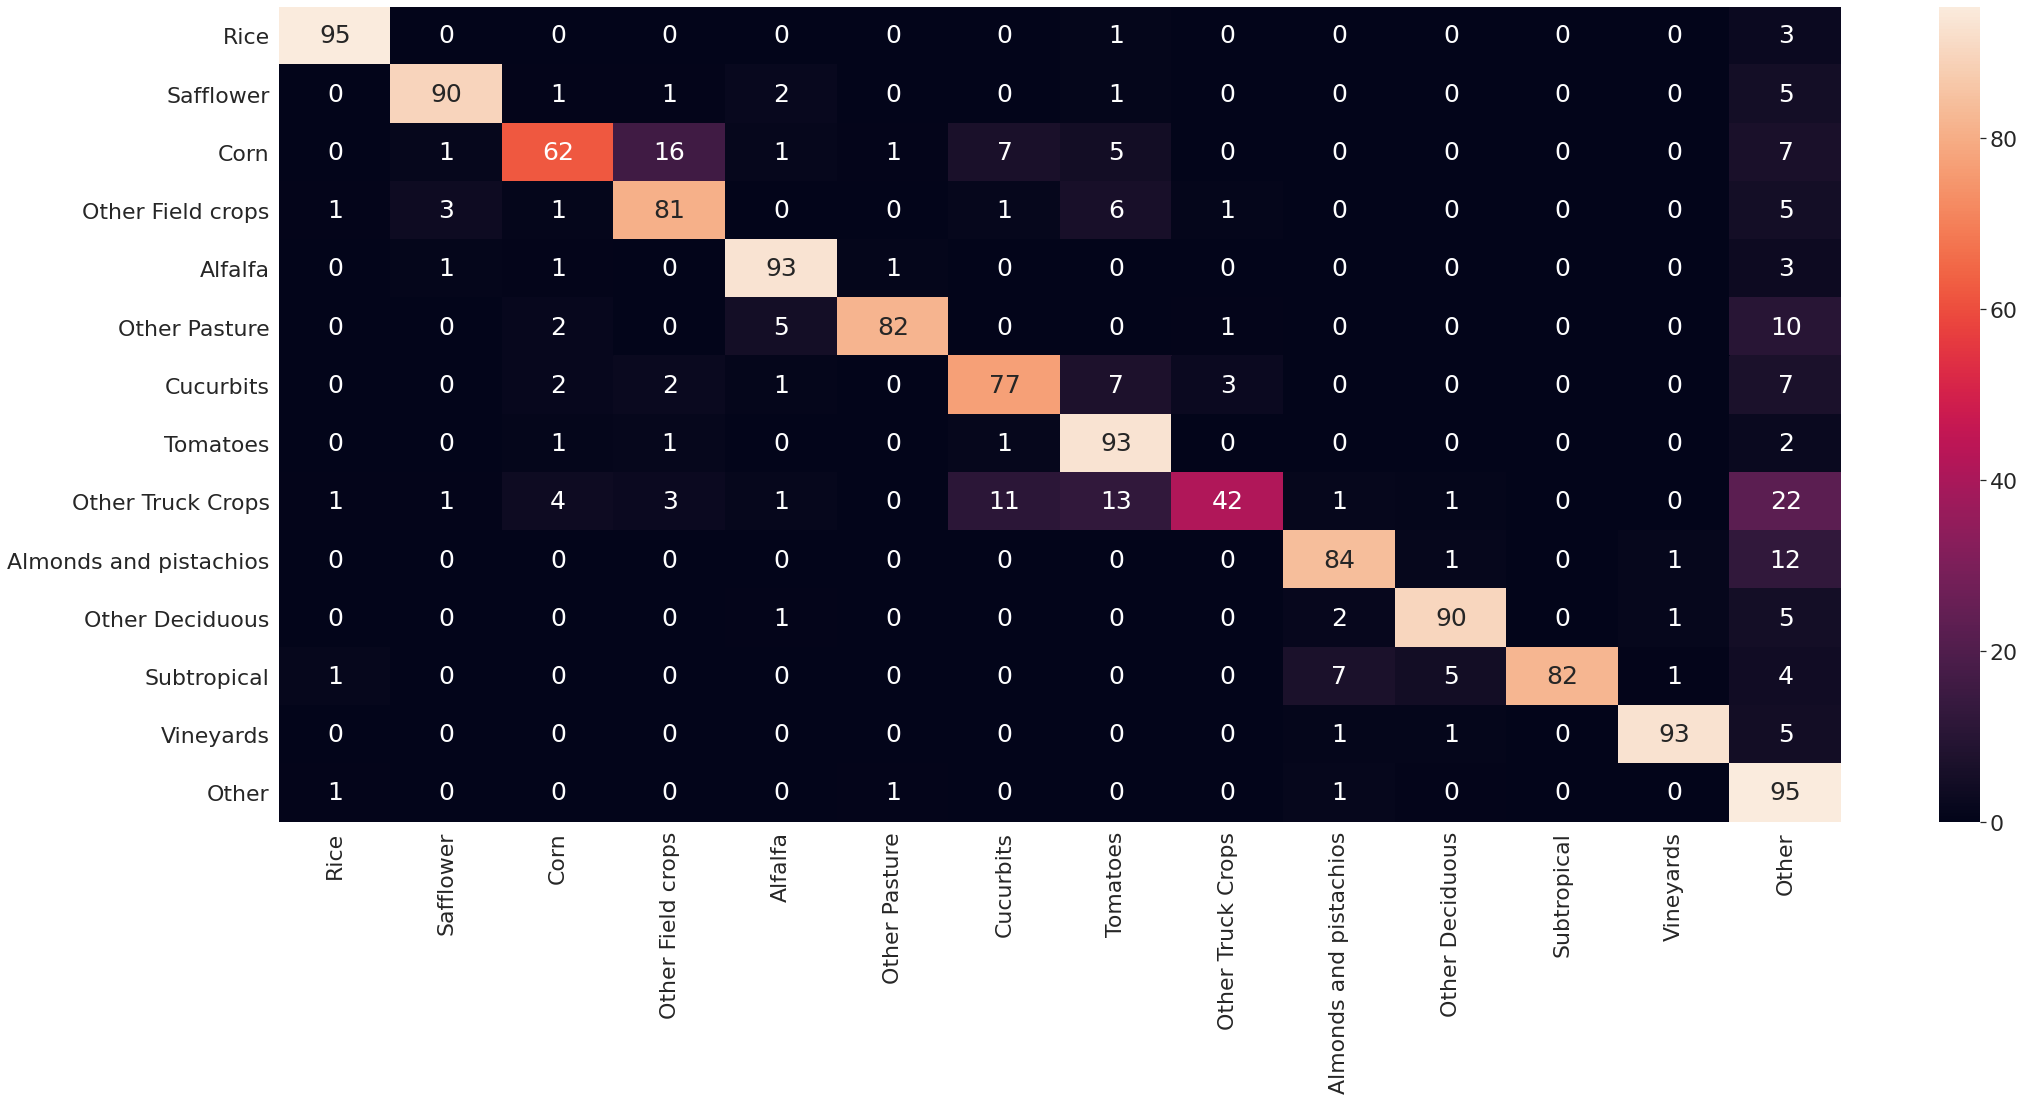

In [ ]:

plt.figure(figsize = (35,15))
sns.set(font_scale=2) 
sns.heatmap(cf1, annot=True, annot_kws={"size": 25},fmt = '.0f')

In [ ]:
np.bincount(y_true)

array([6050, 4773, 3974, 3336, 1308, 1480, 1477, 4710, 1966, 2606, 8230,
        569, 2436, 2095, 4852, 3623, 6077])

In [ ]:
(np.sum(cf, axis = 1)/np.sum(cf))*100

array([12.21805063,  2.96395154,  1.70269557,  5.90737101,  7.69806119,
        3.42738979,  1.71002845,  7.76699029,  1.40644707,  8.61173848,
        3.73097117,  0.79195143,  4.95409615, 37.11025724])